In [29]:
# import basic packages for managing dataframe
import pandas as pd
import numpy as np
from datetime import datetime

# import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# regardless warnings
import warnings 
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# import model package 
# regression and classification
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

#clustering
from sklearn.cluster import KMeans

# import measurement package
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn import metrics


# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Run Preprocessing pipeline first

#### If you have already have train and test, you can skip this step

In [2]:
#required libraries: pandas, sklearn, bs4, nltk, collections, re

#run the following four lines if the below objects are not present in your environment
# import nltk
# nltk.download('tagsets')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

import pandas as pd
import shape_data
import text_analysis
import get_counts_and_frequencies



#either removes missing values or inserts '' for string and 0 for numeric
#df: type DataFrame
#remove: type = boolean
#return: type DataFrame

def missing_values(df, remove=False):
    df['Missing_Value'] = 0

    df_c = df[df['Body'].notna()]
    df_m = df[df['Body'].isna()]

    if(remove):
        df_c = df_c.drop(['Missing_Value'], axis = 1)
        df_c = df_c.fillna(0)
        df_m = df_m.fillna(0)
        df_m.to_csv('mssing_article_bodies.csv', index=False)
        return df_c
    else:
        df_m['Body'] = ''
        df_m['Body_Lemm'] = ''
        df_m['Body_Lemm_lower'] = ''
        df_m['Body_Length'] = 0
        df_m.iloc[:, 12:] = 0
        df_m['Missing_Value'] = 1
        df_c = df_c.fillna(0)
        df_m = df_m.fillna(0)
        return pd.concat([df_c, df_m])



print('Importing data...') 
df1 = pd.read_csv('Prod_FinalData2.csv')
df2 = pd.read_excel('XML.xlsx', header=1)
df3 = pd.read_csv('PublicArticlesWithEndDate.csv', encoding="ISO-8859-1")
print('Import Complete')
print()

unwanted_tags = ['Bulk Archive', 'External Content Archive', 'Not Searchable in FAST', 'Client / Commercial']
#unwanted_tags = ['Bulk Archive', 'External Content Archive', 'Not Searchable in FAST', 'Client / Commercial', 'IPS / PG', 'PSQN']

train, test = shape_data.shape_data(df1, df2, df3, unwanted_tags, language = 'en_US', tag_count_max = 20, train_prop = 0.8, tag_freq_ceil = 200, store_tag_data=True)

print('Training Set:')
train = text_analysis.text_analysis(train)
train = missing_values(train, remove = True)

print('Test Set:')
test = text_analysis.text_analysis(test)
test = missing_values(test, remove = True)

#Keywords
by_tag = True
if(by_tag):
    article_word_list, title_word_list = get_counts_and_frequencies.get_keywords_by_tag(train, df1, article_word_count=500, title_word_count=100)
else:
    article_word_list, title_word_list = get_counts_and_frequencies.get_keywords_by_article(train, article_word_count=500, title_word_count=100)
train = get_counts_and_frequencies.get_counts_and_frequencies(train, article_keywords=article_word_list, title_keywords=title_word_list)
test = get_counts_and_frequencies.get_counts_and_frequencies(test, article_keywords=article_word_list, title_keywords=title_word_list)


train.to_csv('train_tfidf_by_article.csv', index=False)
test.to_csv('test_tfidf_by_article.csv', index=False)

Importing data...


KeyboardInterrupt: 

In [2]:
df_train = pd.read_csv('train_tfidf_by_article.csv',engine='python')
df_test = pd.read_csv('test_tfidf_by_article.csv',engine='python')

### remove those row with tags not included in top 200 tag list

In [3]:
def remove_no_tag(df):
    mask = (df.Tags=='[]')
    df_new = df[~mask]
    return df_new

In [4]:
df_train_new = remove_no_tag(df_train)
df_test_new = remove_no_tag(df_test)

In [5]:
print('Remove ', round(100*(len(df_train)-len(df_train_new))/len(df_train),2) ,'% rows in train data')
print('Remove ', round(100*(len(df_test)-len(df_test_new))/len(df_test),2) ,'% rows in test data')

Remove  88.68 % rows in train data
Remove  89.67 % rows in test data


# 2. Shape Y and X

In [98]:
columns_not_include = ['RECORDID','Tags','Tag_Count' 'Vec_Tags', 'Body', 'Body_Lemm',
       'Body_Lemm_lower', 'Body_Token','Body_Length','Title', 'Title_Lemm',
       'Title_Lemm_lower', 'Title_Token']

# split train and test
X_train = df_train_new.loc[:, ~df_train_new.columns.isin(columns_not_include)]

X_test = df_test_new.loc[:, ~df_test_new.columns.isin(columns_not_include)]


In [99]:
X_train= X_train.iloc[:,2:]
X_test= X_test.iloc[:,2:]

# 3. Run PCA to reduce dimensions

In [100]:
def trans_pca(df, variance):

    scaler = StandardScaler()
    # fit on training set only.
    scaler.fit(df)
    # apply transform to both the training set and the test set.
    df = scaler.transform(df)

    # variance = 0.9 indicates retaining 90% of total variance
    pca = PCA(variance)
    pca.fit(df)
    # print(pca.n_components_)
    df = pca.transform(df)

    return df

In [101]:
# Run PCA for the total dataset(Train+Test)

#X_total = pd.concat([X_train, X_test])
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(0.9)
pca.fit(X_train)
X_train = pd.DataFrame(pca.transform(X_train))
X_test = pd.DataFrame(pca.transform(X_test))



In [102]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,348,349,350,351,352,353,354,355,356,357
0,-1.376886,-4.558389,-2.303191,2.341740,-1.046694,1.259042,-0.174501,-0.955146,0.892875,0.239773,...,0.866454,0.776088,0.692810,0.145963,1.539494,0.776301,0.834870,1.043618,0.955825,0.277469
1,-1.213376,-4.529082,-3.500085,-0.353520,-1.652923,0.811767,-0.708826,-0.069964,-2.076337,0.474541,...,-4.612725,-0.476063,-0.887306,0.084684,-0.022872,-1.041741,0.999579,-0.523575,0.431433,0.439285
2,-1.766296,-3.881214,1.195875,-1.558418,-1.306800,0.502490,0.859281,-1.220420,-2.236194,3.601433,...,-0.049346,-0.300433,-0.612313,1.295534,1.530384,-0.529494,-0.403278,-0.218085,-0.665081,-0.166231
3,-2.698031,-4.316504,-3.267044,2.159892,-1.006441,0.985140,-0.636392,0.164087,1.616541,-0.242710,...,1.700877,-0.029327,1.067114,1.745685,1.493790,-0.499734,0.251122,-0.402530,0.159834,-2.197763
4,-1.530373,-5.015418,-1.731398,1.439094,-3.285464,1.467222,1.006089,-1.302441,-1.411061,0.423619,...,-0.834307,-0.916142,0.619079,0.264628,-0.263189,0.209672,0.207257,-1.030038,0.369709,0.032081


In [103]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,348,349,350,351,352,353,354,355,356,357
0,-1.731941,-4.554403,-2.923628,1.340392,-4.385999,2.059797,0.258837,0.203904,-0.544258,-2.732573,...,0.072024,-0.297059,0.398723,-0.126840,0.083212,0.338953,-0.315320,0.347909,0.350095,0.038505
1,-2.885193,-5.161774,-5.448608,0.210428,7.121600,-3.232407,-2.074334,-0.513254,12.456180,0.621649,...,-0.219520,-1.494103,0.879482,-0.186863,-0.703797,-1.963521,0.700880,0.609754,-0.585788,-1.439632
2,1.187347,-5.833571,7.423673,-9.677803,3.078335,-6.646675,9.567036,6.743762,-6.303436,-1.425585,...,-0.002884,0.404199,0.360780,0.500332,0.253819,0.247051,-0.405149,0.003653,-1.080289,0.298331
3,-1.016203,-3.782767,2.614683,-7.024789,1.767620,-3.354640,20.020260,21.747774,-6.338019,8.258870,...,-0.399729,0.214544,-1.028917,-0.717232,-1.443142,-2.405186,4.453239,-1.286673,-1.679559,-1.798437
4,-1.325283,-4.873388,-2.534988,0.736516,-2.442632,0.402117,0.818656,-1.428100,0.725133,-1.958318,...,1.201960,-0.173798,0.406563,1.041244,-0.443548,-0.578419,-0.790603,1.044117,-0.021026,-0.780091


# 4. Try models

## 1. logistic Regression

In [104]:
accuracy = []
f1_score=[]
roc = []
# compute how many 1 in each model
sum_train=[]
sum_test=[]

# only try first 10
for num_models in range(0,10): 
    # create y_train and y_test
    y_train = []
    y_test = []
    for i  in range(len(df_train_new)):
        y_train.append(int(df_train_new['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    for j  in range(len(df_test_new)):
        y_test.append(int(df_test_new['Vec_Tags'].iloc[j].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    
    sum_train.append(sum(y_train))
    sum_test.append(sum(y_test))
    # logistic regression
    lg = LogisticRegression().fit(X_train, y_train)
    y_pred_lg_test = lg.predict(X_test)
    y_pred_lg_train = lg.predict(X_train)
    y_score_lg_test = lg.predict_proba(X_test)[:,1]
    y_score_lg_train = lg.predict_proba(X_train)[:,1]
    acc_lg = accuracy_score(y_test, y_pred_lg_test)
    f1_score_lg = metrics.f1_score(y_test, y_pred_lg_test)
    roc_lg = metrics.roc_auc_score(y_test, y_pred_lg_test)
    accuracy.append(acc_lg)
    f1_score.append(f1_score_lg)
    roc.append(roc_lg)
    
    # create new column: the predict result for the next model
    X_train['predict_'+str(num_models)] = y_score_lg_train
    X_test['predict_'+str(num_models)] = y_score_lg_test

In [76]:
data_tuples = list(zip(accuracy,f1_score,roc,sum_train,sum_test))
result = pd.DataFrame(data_tuples,columns=['accuracy','f1_score','roc','sum_train','sum_test'])
result['sum_train'] = result['sum_train']/len(y_train)
result['sum_test'] = result['sum_test']/len(y_test)

In [77]:
result

,accuracy,f1_score,roc,sum_train,sum_test
0,0.994609,0.961538,0.997110,0.086663,0.067385
1,0.986523,0.878049,0.891304,0.062077,0.061995
2,0.986523,0.878049,0.907658,0.061463,0.059299
3,0.975741,0.861538,0.897024,0.060234,0.094340
4,0.973046,0.843750,0.882738,0.060234,0.094340
5,0.997305,0.960000,0.961538,0.039951,0.035040
6,0.997305,0.952381,0.954545,0.031346,0.029650
7,0.989218,0.714286,0.811123,0.028273,0.021563
8,0.975741,0.181818,0.577854,0.019668,0.016173
9,1.000000,1.000000,1.000000,0.019053,0.024259


In [262]:
df_sum_list_test = pd.DataFrame(sum_list_test)
len(df_sum_list_test[df_sum_list_test[0] == 0])
# there are 23 models  that only contain 0 in test dataset

23

In [52]:
df_accuracy = pd.DataFrame(accuracy)
df_accuracy['Number_correct'] = df_accuracy[0]*len(X_train)

In [54]:
df_accuracy

,0,Number_correct
0,0.997494,14331.002506
1,0.997216,14327.002784
2,0.990813,14235.009187
3,0.990813,14235.009187
4,0.997494,14331.002506
...,...,...
194,1.000000,14367.000000
195,1.000000,14367.000000
196,0.999722,14363.000278
197,0.999722,14363.000278


In [53]:
sum(df_accuracy['Number_correct'])/(200*len(X_train))

0.9939685412026735

## 2. Random Forest

In [79]:
# Recreate X_train and X_test again
X_train = df_train_new.loc[:, ~df_train_new.columns.isin(columns_not_include)]

X_test = df_test_new.loc[:, ~df_test_new.columns.isin(columns_not_include)]


In [80]:
X_train= X_train.iloc[:,2:]
X_test= X_test.iloc[:,2:]

In [81]:
# Run PCA for the total dataset(Train+Test)

#X_total = pd.concat([X_train, X_test])
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(0.9)
pca.fit(X_train)
X_train = pd.DataFrame(pca.transform(X_train))
X_test = pd.DataFrame(pca.transform(X_test))



In [82]:
accuracy_rf = []
f1_score_rf = []
roc_rf = []

# compute how many 1 in each model
sum_train=[]
sum_test=[]

# Try first 10 models
for num_models in range(0,10): 
    # create train and test
    y_train = []
    y_test = []
    for i  in range(len(df_train_new)):
        y_train.append(int(df_train_new['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    for j  in range(len(df_test_new)):
        y_test.append(int(df_test_new['Vec_Tags'].iloc[j].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    
    sum_train.append(sum(y_train))
    sum_test.append(sum(y_test))
    
    # Random Forest
    rf = RandomForestClassifier(max_depth=10,class_weight='balanced').fit(X_train, y_train)
    y_pred_rf_test = rf.predict(X_test)
    y_pred_rf_train = rf.predict(X_train)
    y_score_rf = rf.predict_proba(X_test)[:,1]
    acc_rf = accuracy_score(y_test, y_pred_rf_test)
    f1_score_rf_result = metrics.f1_score(y_test, y_pred_rf_test)
    roc_rf_result = metrics.roc_auc_score(y_test, y_score_rf)
    accuracy_rf.append(acc_rf)
    f1_score_rf.append(f1_score_rf_result)
    roc_rf.append(roc_rf_result)
    
    # create new column: the predict result for the next model
    X_train['predict_'+str(num_models)] = y_pred_rf_train
    X_test['predict_'+str(num_models)] = y_pred_rf_test

In [83]:
data_tuples = list(zip(accuracy_rf,f1_score_rf,roc_rf,sum_train,sum_test))
result_rf = pd.DataFrame(data_tuples,columns=['accuracy','f1_score','roc','sum_train','sum_test'])
result_rf['sum_train'] = result_rf['sum_train']/len(y_train)
result_rf['sum_test'] = result_rf['sum_test']/len(y_test)
result_rf

,accuracy,f1_score,roc,sum_train,sum_test
0,0.994609,0.960000,0.999538,0.086663,0.067385
1,0.983827,0.850000,0.999750,0.062077,0.061995
2,0.978437,0.789474,0.996744,0.061463,0.059299
3,0.959569,0.736842,0.989286,0.060234,0.094340
4,0.959569,0.736842,0.984566,0.060234,0.094340
5,0.975741,0.470588,0.998066,0.039951,0.035040
6,0.991914,0.842105,0.998737,0.031346,0.029650
7,0.983827,0.400000,0.987603,0.028273,0.021563
8,0.981132,0.000000,0.864840,0.019668,0.016173
9,0.989218,0.714286,1.000000,0.019053,0.024259


# 3. Linear SVM

In [84]:
# Recreate X_train and X_test again
X_train = df_train_new.loc[:, ~df_train_new.columns.isin(columns_not_include)]

X_test = df_test_new.loc[:, ~df_test_new.columns.isin(columns_not_include)]


X_train= X_train.iloc[:,2:]
X_test= X_test.iloc[:,2:]

In [85]:
# Run PCA for the total dataset(Train+Test)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(0.9)
pca.fit(X_train)
X_train = pd.DataFrame(pca.transform(X_train))
X_test = pd.DataFrame(pca.transform(X_test))

In [86]:
accuracy_svm = []
f1_score_svm = []
roc_svm = []

# compute how many 1 in each model
sum_train=[]
sum_test=[]

# Try first 10 models
for num_models in range(0,10): 
    # create train and test
    y_train = []
    y_test = []
    for i  in range(len(df_train_new)):
        y_train.append(int(df_train_new['Vec_Tags'].iloc[i].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    for j  in range(len(df_test_new)):
        y_test.append(int(df_test_new['Vec_Tags'].iloc[j].split(']')[0].split('[')[1].split(',')[num_models].rstrip(' ').lstrip(' ')))
    
    sum_train.append(sum(y_train))
    sum_test.append(sum(y_test))
    
    # Random Forest
    svm = LinearSVC().fit(X_train, y_train)
    y_pred_svm_test = svm.predict(X_test)
    y_pred_svm_train = svm.predict(X_train)
 #   y_score_svm = svm.predict_proba(X_test)[:,1]
    acc_svm = accuracy_score(y_test, y_pred_svm_test)
    f1_score_svm_result = metrics.f1_score(y_test, y_pred_svm_test)
#    roc_svm_result = metrics.roc_auc_score(y_test, y_score_svm)
    accuracy_svm.append(acc_svm)
    f1_score_svm.append(f1_score_svm_result)
 #   roc_svm.append(roc_svm_result)
    
    # create new column: the predict result for the next model
    X_train['predict_'+str(num_models)] = y_pred_svm_train
    X_test['predict_'+str(num_models)] = y_pred_svm_test

In [87]:
data_tuples = list(zip(accuracy_svm,f1_score_svm,sum_train,sum_test))
result_svm = pd.DataFrame(data_tuples,columns=['accuracy','f1_score','sum_train','sum_test'])
result_svm['sum_train'] = result_svm['sum_train']/len(y_train)
result_svm['sum_test'] = result_svm['sum_test']/len(y_test)
result_svm

,accuracy,f1_score,sum_train,sum_test
0,0.970350,0.819672,0.086663,0.067385
1,0.970350,0.775510,0.062077,0.061995
2,0.970350,0.765957,0.061463,0.059299
3,0.951482,0.742857,0.060234,0.094340
4,0.951482,0.742857,0.060234,0.094340
5,0.978437,0.733333,0.039951,0.035040
6,0.989218,0.833333,0.031346,0.029650
7,0.981132,0.631579,0.028273,0.021563
8,0.946092,0.230769,0.019668,0.016173
9,1.000000,1.000000,0.019053,0.024259


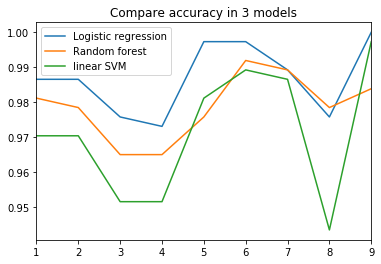

In [64]:
plt.plot(result.accuracy,label='Logistic regression')
plt.plot(result_rf.accuracy,label='Random forest')
plt.plot(result_svm.accuracy,label='linear SVM')
plt.title('Compare accuracy in 3 models')
plt.xlim(1,9)
plt.legend()
plt.show()

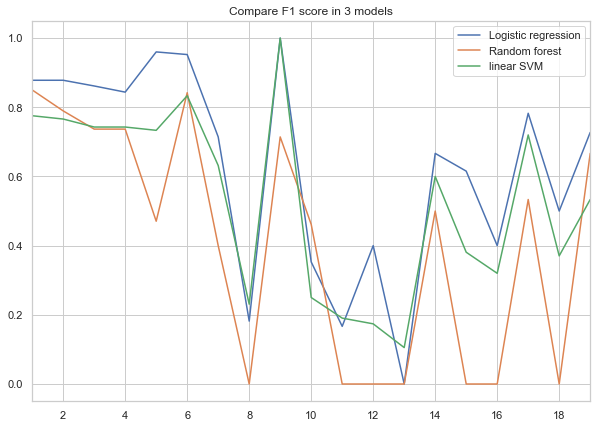

In [91]:
plt.figure(figsize=(10,7))
plt.plot(result.f1_score,label='Logistic regression')
plt.plot(result_rf.f1_score,label='Random forest')
plt.plot(result_svm.f1_score,label='linear SVM')
plt.title('Compare F1 score in 3 models')
plt.xlim(1,19)
plt.legend()
plt.show()

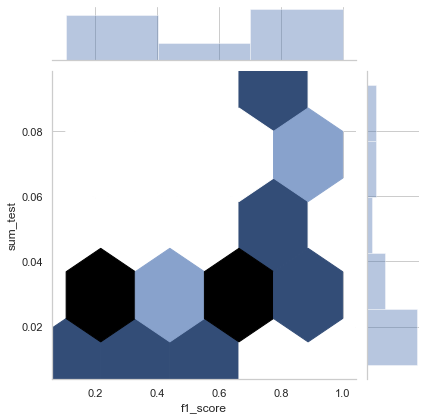

In [92]:
# See the correlations between FICO score and interest rate
sns.set(style="whitegrid")
ax = sns.jointplot("f1_score", "sum_test", result_svm, kind="hex")


# Deal with imbalanced Data

In [2]:
df_high_count= pd.read_csv('high_count_tags.csv')

In [6]:
df_high_count.Tag_Count.describe()

count    343.000000
mean      46.889213
std       35.700828
min       21.000000
25%       25.000000
50%       33.000000
75%       56.000000
max      282.000000
Name: Tag_Count, dtype: float64

In [190]:
def get_tag_list(df):
    tag_list = []
    for i in range(len(df)):
        if df['Tags'].iloc[i]== '[]':
            pass
        else: 
            for j in df['Tags'].iloc[i].split('[')[1].split(']')[0].split(','):
                tag_list.append(j.rstrip().lstrip())
    return tag_list

In [191]:
tag_list = pd.DataFrame(get_tag_list(df_train))
tag_list[0].value_counts().describe()

count    200.000000
mean      14.910000
std       16.934159
min        6.000000
25%        8.000000
50%       10.000000
75%       15.000000
max      141.000000
Name: 0, dtype: float64

In [194]:
tag_list_new = pd.DataFrame(get_tag_list(df_train_new))
tag_list_new[0].value_counts().describe()

count    200.000000
mean      14.910000
std       16.934159
min        6.000000
25%        8.000000
50%       10.000000
75%       15.000000
max      141.000000
Name: 0, dtype: float64

In [228]:
tag_list_test = pd.DataFrame(get_tag_list(df_test_new))
tag_list_test[0].value_counts().describe()

count    177.000000
mean       3.926554
std        4.902484
min        1.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       35.000000
Name: 0, dtype: float64

In [181]:
tag_list[0].value_counts()[:1].index.values

array(["'Replace Parts'"], dtype=object)

In [192]:
# Top 20 frequent occuring tag in train dataset 
tag_list[0].value_counts()[:20]

'Replace Parts'                                          141
'Isilon OneFS'                                           101
'Isilon'                                                 100
'Compellent (SC'                                          98
'SCv & FS Series)'                                        98
'Dell Endpoint Security Suite Enterprise'                 65
'Dell Security Tools'                                     51
'Dell Threat Defense'                                     46
'Precision 7920 Tower'                                    32
'Security Advisory'                                       31
'No Network or Internet'                                  31
'Precision 5820 Tower'                                    30
'Dell Dock WD15'                                          30
'High Performance Computing Solution Resources'           29
'Precision 7820 Tower'                                    29
'Dell Precision Dual USB-C Thunderbolt Dock - TB18DC'     26
'Social Media'          

In [193]:
# Total number of unique tag
len(tag_list[0].value_counts())

200